In [1]:
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Embedding, SimpleRNN, GlobalMaxPooling1D, GRU, Bidirectional, Layer, ActivityRegularization
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from keras.models import Sequential
import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras import regularizers

In [2]:
char_set = list(
    " abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789-'\"/+*.,!?;:()[]{}><@#$%^&=~`_|\\")
char_set = [''] + char_set

char2int = {char_set[x]: x for x in range(len(char_set))}
int2char = {x: char_set[x] for x in range(len(char_set))}

# char2int

# Character Encoding

In [3]:

dataset = pd.read_csv(
    'sheet1.csv', usecols=["target_new", "INPUT", "Input_error"])


dataset["Y"] = dataset["Input_error"].map({"Cat A": 0, "Cat B": 1, "Cat C": 2, "Cat D": 3})
dataset["X"] = dataset["target_new"] + "" + dataset["INPUT"]
dataset = dataset.drop(["target_new","INPUT","Input_error"], axis=1)
# print(dataset["X"].head())
# tokenizer = Tokenizer(num_words=1000)
# tokenizer.fit_on_texts(dataset["X"].astype(str))
# dataset["X"] = tokenizer.texts_to_sequences(dataset["X"].astype(str))

dataset["X"] = dataset["X"].apply(lambda x: [char2int[i] for i in str(x)])

dataset["X"] = dataset["X"].apply(lambda x: np.array(x))
dataset["Y"] = dataset["Y"].apply(lambda x: np.array(x))

# padding the data for equal length
max_len = dataset["X"].apply(lambda x: len(x)).max()
dataset["X"] = dataset["X"].apply(lambda x: pad_sequences([x], maxlen=max_len,padding="post",truncating="post")[0])
dataset["X"] = dataset["X"].apply(lambda x: np.array(x))
dataset.dropna(inplace=True)
print(max_len)

686


In [4]:
x_train, x_test, y_train, y_test = train_test_split(dataset["X"], dataset["Y"], test_size=0.2, random_state=42)
sm = SMOTE(random_state=25)

x_train, y_train = sm.fit_resample(np.array(x_train.tolist()), np.array(y_train.tolist()))

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


In [5]:
len(x_val)

7993

In [6]:
print(type(x_train),type(x_test))
early_stop = EarlyStopping(monitor='accuracy', patience=3, verbose=1)

<class 'numpy.ndarray'> <class 'pandas.core.series.Series'>


In [7]:
# RNN with GRU
model = Sequential()
model.add(Embedding(input_dim=1000, output_dim=32, input_length=max_len))
model.add(Bidirectional(GRU(32, activation='relu', return_sequences=True)))
model.add(Bidirectional(GRU(16, activation='relu')))
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 686, 32)           32000     
                                                                 
 bidirectional (Bidirectiona  (None, 686, 64)          12672     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               7872      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 54,916
Trainable params: 54,916
Non-traina

In [8]:
with tf.device(tf.test.gpu_device_name()):
    history = model.fit(x_train, y_train, epochs=30, batch_size=64, validation_data=(x_val, y_val))

Epoch 1/30
500/500 [==============================] - 228s 448ms/step - loss: 0.9679 - accuracy: 0.5280 - val_loss: 0.8608 - val_accuracy: 0.6198
Epoch 2/30
500/500 [==============================] - 247s 494ms/step - loss: 0.8587 - accuracy: 0.6071 - val_loss: 0.8628 - val_accuracy: 0.6072
Epoch 3/30
500/500 [==============================] - 240s 479ms/step - loss: 0.8499 - accuracy: 0.6111 - val_loss: 0.8411 - val_accuracy: 0.6250
Epoch 4/30
500/500 [==============================] - 240s 481ms/step - loss: 0.8421 - accuracy: 0.6178 - val_loss: 0.8457 - val_accuracy: 0.6135
Epoch 5/30
500/500 [==============================] - 232s 464ms/step - loss: 0.8376 - accuracy: 0.6223 - val_loss: 0.8358 - val_accuracy: 0.6239
Epoch 6/30
500/500 [==============================] - 221s 442ms/step - loss: 0.8312 - accuracy: 0.6248 - val_loss: 0.8313 - val_accuracy: 0.6309
Epoch 7/30
500/500 [==============================] - 219s 438ms/step - loss: 0.8279 - accuracy: 0.6262 - val_loss: 0.8247 -

In [9]:
results = model.evaluate(np.array(x_test.tolist()), np.array(y_test.tolist()))
print("test loss, test acc:", results)

161/161 [==============================] - 14s 86ms/step - loss: 0.7977 - accuracy: 0.6715
test loss, test acc: [0.7976737022399902, 0.6715229153633118]


In [10]:
model.save('model_final.h5')

# Testing using Saved Model

In [12]:
import tensorflow as tf

# Load the pre-trained model
model = tf.keras.models.load_model('model_final.h5')  # Replace with your actual file path


In [13]:
predict = model.predict(x_val)

print("test loss, test acc:", predict)
print(type(predict))

250/250 [==============================] - 21s 80ms/step
test loss, test acc: [[1.0981511e-03 3.5823533e-09 5.6095619e-02 9.4280624e-01]
 [6.9362867e-01 2.6073191e-01 2.5093615e-02 2.0545777e-02]
 [6.2338096e-01 3.2352427e-01 2.5297740e-02 2.7797058e-02]
 ...
 [5.6030381e-01 5.0989292e-03 3.6818635e-01 6.6410929e-02]
 [4.7848114e-01 4.7506490e-01 1.0722463e-02 3.5731506e-02]
 [7.3514923e-02 1.6248001e-05 6.2099499e-01 3.0547377e-01]]
<class 'numpy.ndarray'>


In [14]:
y_pred = np.argmax(predict,axis = 1)


# Confusion Matrix

Confusion Matrix:
[[1229  607  131   33]
 [ 358 1632    0    2]
 [  86   57 1212  671]
 [  44  267  288 1376]]


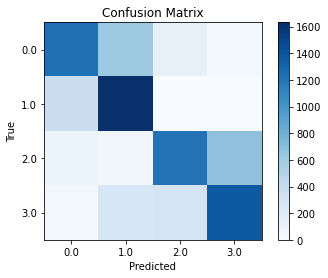

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# # True labels
# true_labels = [0, 1, 2, 1, 0, 3, 2, 0, 1, 2, 3, 3]

# # Predicted labels
# predicted_labels = [0, 2, 1, 1, 0, 3, 2, 0, 2, 2, 3, 1]

# Calculate confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_val)))
plt.xticks(tick_marks, np.unique(y_val))
plt.yticks(tick_marks, np.unique(y_val))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Graphs

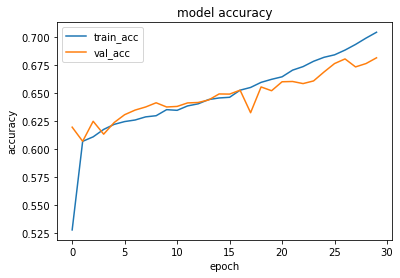

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.show()

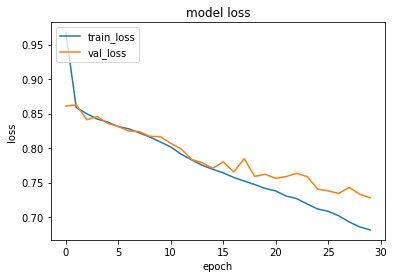

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

In [2]:
def predict(input_new):
  input_new =  input_new
  input_new = [char2int[i] for i in str(input_new)]
  input_new = pad_sequences([input_new], maxlen=max_len,padding="post",truncating="post")[0]
  input_new = np.array(input_new)
  input_new = np.array([input_new])
  print(input_new)
  return model.predict(input_new)


input_new = "I am eating bricks"

pridiction = predict(input_new)
print("test loss, test acc:", pridiction)
print(np.argmax(pridiction))



NameError: name 'char2int' is not defined